<a href="https://colab.research.google.com/github/Antonio-Velasco/rnn_multiclass_example/blob/main/multiclass_nn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook demonstrates the development of a Recurrent Neural Network (RNN) model for classifying news articles into one of two classes. Using PyTorch, the model processes sequential data with an RNN layer to capture patterns, a dropout layer to prevent overfitting, and a fully connected layer for predictions. The model is trained and evaluated, showing effective performance in accurately classifying the news articles.

### Unzip and Extract dataset

In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Notebooks/ll_ds_interview_dataset_1_2_2024.zip'
extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Load the index_mapping

In [3]:
import json

json_path = '/content/data/index_mapping.json'

with open(json_path, 'r') as file:
    data = json.load(file)
print(data)

{'1': 'World', '2': 'Sports'}


Load the dataset

In [4]:
import pandas as pd

df = pd.read_csv("/content/data/test_set.csv")

print(f'df dimensions: {df.shape}')
df.sample(10)

df dimensions: (3800, 3)


,Class Index,Title,Description
106,1,Burundi Police Forcibly Disperse Tutsi Protest,"Police in Burundi #39;s capital, Bujumbura, us..."
3319,2,Former Basketball Player Found Dead (AP),"AP - Mark Haymore, who played on Indiana's unb..."
982,1,"Freedom on the March in Iraq, Bush Tells Voter...",Reuters - President Bush said on\Thursday free...
1433,2,NFL: QB shuffle: Miami gives Fiedler the ball,"By all accounts, Jay Fiedler is a good guy. He..."
1562,2,"AL Wrap: Indians, Twins Split Unique Doubleheader",NEW YORK (Reuters) - Ben Broussard belted a t...
214,2,SI.com,HOUSTON (Ticker) -- Kerry Wood got plenty of r...
2270,2,Long and short of a rivalry that was,"Five years may not seem a whole lot, but consi..."
940,2,McKenzie Ends Holdout and Returns to Green Bay...,Reuters - Green Bay Packers\cornerback Mike Mc...
280,1,US not involved in Afghan vigilante trial-offi...,An Afghan court was following proper procedure...
3461,1,US sends marines to Philippines,The US is sending up to 600 marines and relief...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  3800 non-null   int64 
 1   Title        3800 non-null   object
 2   Description  3800 non-null   object
dtypes: int64(1), object(2)
memory usage: 89.2+ KB


## Exploration of the data

In [6]:
df['Text'] = df.apply(lambda x: x['Title'] + ' ' + x['Description'], axis=1)
df['Text_lenght'] = df['Text'].apply(lambda x: len(x.split()))

In [7]:
df.describe()

,Class Index,Text_lenght
count,3800.000000,3800.000000
mean,1.500000,38.056316
std,0.500066,9.449412
min,1.000000,15.000000
25%,1.000000,32.000000
50%,1.500000,38.000000
75%,2.000000,43.000000
max,2.000000,106.000000


## NLP preprocessing

In [8]:
df['Text'][0]

'Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8.26 seconds.'

In [9]:
import re
from itertools import chain

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# ==============================================
# ============  NLP  Processing  ===============
# ==============================================

# Download resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


def onlyalphabetic(input: str, with_space: bool = True) -> str:
    # Matches every non alphabetical character
    regex = '[^a-zA-Z ]'
    if with_space:
        return re.sub(regex, " ", input)
    else:
        return re.sub(regex, "", input)


def lowercase(input: str) -> str:
    # Makes text lowercase
    return input.lower()


def removestopwords(input: list[str], *args: str) -> list[str]:
    # Removes common English stopwords and custom ones added as *args
    return [t for t in input if t not in list(
            chain(*[[*args],
                    stopwords.words('english')])
            )]


def lemmatizer(input: list[str]) -> list[str]:
    # Lemmatizes tokens
    return [WordNetLemmatizer().lemmatize(t, pos=wordnet.VERB) for t in input]



def cleantext(text: str) -> str:
    text = lowercase(text)
    text = onlyalphabetic(text, with_space=False)
    text = nltk.word_tokenize(text)
    text = removestopwords(text)
    text = lemmatizer(text)
    text = ' '.join(text)
    return text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [10]:
cleantext(df['Text'][0])

'giddy phelps touch gold first time michael phelps gold medal individual medley set world record time minutes second'

In [11]:
df['clean_text'] = df['Text'].apply(cleantext)

In [12]:
df.head()

,Class Index,Title,Description,Text,Text_lenght,clean_text
0,2,Giddy Phelps Touches Gold for First Time,Michael Phelps won the gold medal in the 400 i...,Giddy Phelps Touches Gold for First Time Micha...,31,giddy phelps touch gold first time michael phe...
1,2,Tougher rules won't soften Law's game,FOXBOROUGH -- Looking at his ridiculously deve...,Tougher rules won't soften Law's game FOXBOROU...,67,tougher rule wont soften laws game foxborough ...
2,2,Shoppach doesn't appear ready to hit the next ...,With the weeks dwindling until Jason Varitek e...,Shoppach doesn't appear ready to hit the next ...,70,shoppach doesnt appear ready hit next level we...
3,2,Mighty Ortiz makes sure Sox can rest easy,Just imagine what David Ortiz could do on a go...,Mighty Ortiz makes sure Sox can rest easy Just...,69,mighty ortiz make sure sox rest easy imagine d...
4,2,They've caught his eye,"In quot;helping themselves, quot; Ricky Bryan...",They've caught his eye In quot;helping themse...,35,theyve catch eye quothelping quot ricky bryant...


## Quick fix labels to be 0 and 1

In [13]:
df['class'] = df['Class Index'].apply(lambda x: 0 if x == 1 else 1)

## Let's now produce the embeddings

In [41]:
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [15]:
df['encoded_text'] = df['clean_text'].apply(lambda x: emb_model.encode(x))

In [16]:
df.head()

,Class Index,Title,Description,Text,Text_lenght,clean_text,class,encoded_text
0,2,Giddy Phelps Touches Gold for First Time,Michael Phelps won the gold medal in the 400 i...,Giddy Phelps Touches Gold for First Time Micha...,31,giddy phelps touch gold first time michael phe...,1,"[-0.029852657, 0.021464333, 0.056198522, 0.003..."
1,2,Tougher rules won't soften Law's game,FOXBOROUGH -- Looking at his ridiculously deve...,Tougher rules won't soften Law's game FOXBOROU...,67,tougher rule wont soften laws game foxborough ...,1,"[-0.010199152, -0.016219726, -0.028083237, -0...."
2,2,Shoppach doesn't appear ready to hit the next ...,With the weeks dwindling until Jason Varitek e...,Shoppach doesn't appear ready to hit the next ...,70,shoppach doesnt appear ready hit next level we...,1,"[0.008341988, -0.040940695, -0.04506849, -0.00..."
3,2,Mighty Ortiz makes sure Sox can rest easy,Just imagine what David Ortiz could do on a go...,Mighty Ortiz makes sure Sox can rest easy Just...,69,mighty ortiz make sure sox rest easy imagine d...,1,"[-0.06599269, 0.05781733, 0.032642722, 0.02857..."
4,2,They've caught his eye,"In quot;helping themselves, quot; Ricky Bryan...",They've caught his eye In quot;helping themse...,35,theyve catch eye quothelping quot ricky bryant...,1,"[-0.060756493, -0.009110707, -0.011295048, -0...."


In [50]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Split DataFrame into features and labels
X = torch.Tensor(df['encoded_text'].values.tolist())
y = df['class'].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Split into train and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42)

In [60]:
dataloader = DataLoader(TensorDataset(X_train, torch.Tensor(y_train)), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val, torch.Tensor(y_val)), batch_size=32, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test, torch.Tensor(y_test)), batch_size=32, shuffle=False)

Time to build our model

In [61]:
from torch import nn

class rnn_model(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(rnn_model, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    if x.dim() == 2:  # If x is [batch_size, input_size]
      x = x.unsqueeze(1)  # Add sequence_length dimension, making it [batch_size, 1, input_size]
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out


initialize the model

In [62]:
model = rnn_model(input_size=384, hidden_size=128, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

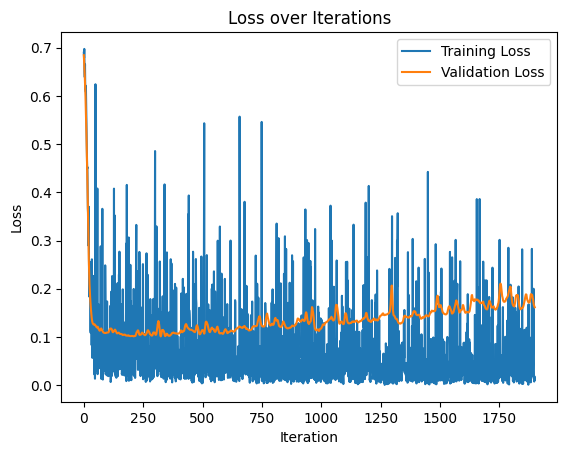

In [63]:
import matplotlib.pyplot as plt

num_epochs = 20

# Initialize a list to store loss values
loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
  model.train()
  for i, (inputs, labels) in enumerate(dataloader):
    # Set the gradients to zero
    optimizer.zero_grad()
    # Run a forward pass
    prediction = model(inputs)
    loss = criterion(prediction, labels.long())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the loss value
    loss_values.append(loss.item())

    # Evaluation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in val_dataloader:
            prediction = model(inputs)
            loss = criterion(prediction, labels.long())
            val_loss += loss.item()

    val_loss /= len(val_dataloader)  # Calculate average validation loss
    val_loss_values.append(val_loss)


# Plotting the loss values
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()
plt.show()


Decreassing loss on training and increasing on validation means overfitting

Hyperparameter tuning

1. Regularization using a dropout layer
2. add weight decay

In [73]:
from torch import nn

class rnn_model(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.2):
    super(rnn_model, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    if x.dim() == 2:  # If x is [batch_size, input_size]
      x = x.unsqueeze(1)  # Add sequence_length dimension, making it [batch_size, 1, input_size]
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = self.dropout(out[:, -1, :])
    out = self.fc(out)
    return out


In [74]:
model = rnn_model(input_size=384, hidden_size=128, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

Rerun

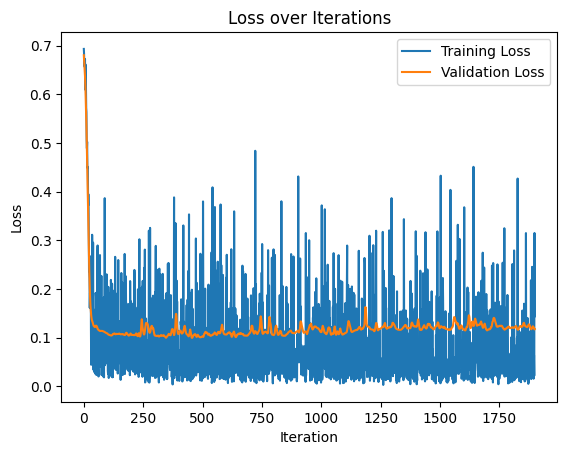

In [75]:
import matplotlib.pyplot as plt

num_epochs = 20

# Initialize a list to store loss values
loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
  model.train()
  for i, (inputs, labels) in enumerate(dataloader):
    # Set the gradients to zero
    optimizer.zero_grad()
    # Run a forward pass
    prediction = model(inputs)
    loss = criterion(prediction, labels.long())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the loss value
    loss_values.append(loss.item())

    # Evaluation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in val_dataloader:
            prediction = model(inputs)
            loss = criterion(prediction, labels.long())
            val_loss += loss.item()

    val_loss /= len(val_dataloader)  # Calculate average validation loss
    val_loss_values.append(val_loss)


# Plotting the loss values
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()
plt.show()


Validation loss no longer creeping upwards

## Let's study Accuracy

In [56]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 21.3 MB/s eta 0:00:00


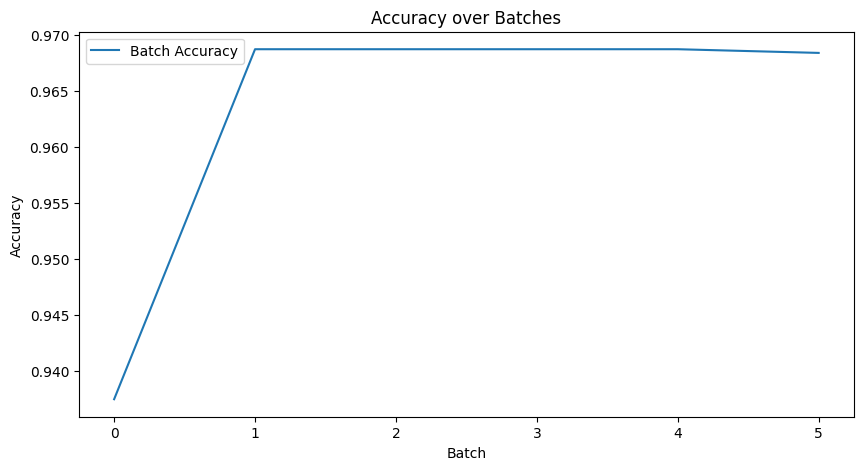

Final Accuracy: 0.9684


In [76]:
import torch
import torchmetrics
import matplotlib.pyplot as plt

# Initialize the accuracy metric
metrics = torchmetrics.Accuracy(task="multiclass", num_classes=2)

# List to store accuracy values for each batch
accuracy_values = []

# Iterate over the test dataloader
for i, data in enumerate(test_dataloader, 0):
    features, labels = data
    outputs = model(features)
    _, predicted = torch.max(outputs, 1)
    metrics.update(predicted, labels)

    # Calculate accuracy for the current batch and store it
    batch_accuracy = metrics.compute().item()
    accuracy_values.append(batch_accuracy)

# Plotting the accuracy values
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values, label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Batches')
plt.legend()
plt.show()

# Print final accuracy
final_accuracy = metrics.compute().item()
print(f'Final Accuracy: {final_accuracy:.4f}')


In [83]:
import pandas as pd

# Find mismatches
mismatches = [i for i in range(len(labels)) if labels[i] != predicted[i]]

# Create a DataFrame to show mismatches
data = {
    'Index': mismatches,
    'True Label': [labels[i] for i in mismatches],
    'Predicted Label': [predicted[i] for i in mismatches]
}

df_mismatches = pd.DataFrame(data)

# Display the table
print(df_mismatches)


   Index  True Label Predicted Label
0     10  tensor(1.)       tensor(0)


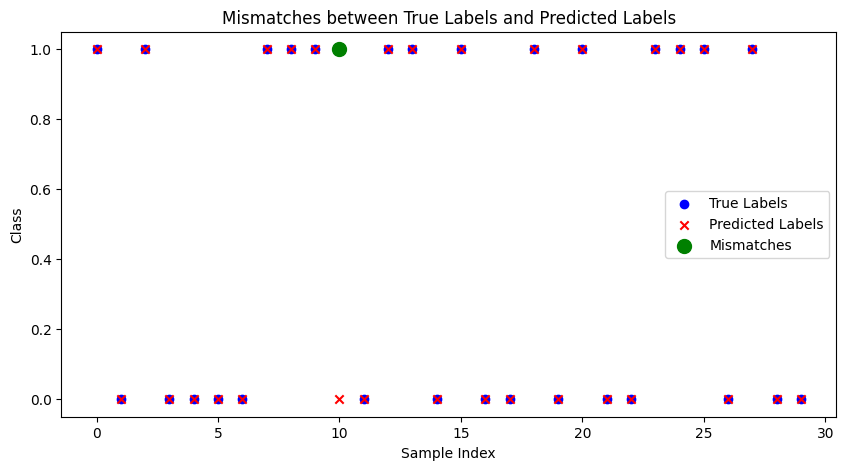

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Find mismatches
mismatches = labels != predicted

# Plotting the mismatches
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(labels)), labels, color='blue', label='True Labels')
plt.scatter(np.arange(len(predicted)), predicted, color='red', label='Predicted Labels', marker='x')
plt.scatter(np.arange(len(labels))[mismatches], labels[mismatches], color='green', label='Mismatches', marker='o', s=100)

plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('Mismatches between True Labels and Predicted Labels')
plt.legend()
plt.show()


In [79]:
predicted

tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0])

In [81]:
labels

tensor([1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.])

High accuracy achieved